# 1D Regression and Dual Updates

In [1]:
from IPython.display import clear_output

import src
import numpy as np
import torch 
import matplotlib.pyplot as plt
from src.custom_types import Data

INFO:absl:MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.
INFO:absl:Successfully imported OpenGL backend: glfw
INFO:absl:MuJoCo library version is: 2.3.3


Let's fix the random seed for reproducibility and set the default type to float64.

In [2]:
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

## Create a toy dataset

Let's start by creating a simple 1D regression data set, with inputs $\mathbf{x}_i \in \mathbb{R}$ and outputs $\mathbf{y}_i \in \mathbb{R}$. We assume that each output $\mathbf{y}_i$ is generated by mapping the corresponding input $\mathcal{x}_i$ through a latent function $f : \mathbb{R} \rightarrow \mathbb{R}$ subject i.i.d. Gaussian noise,
$$
\mathbf{y}_i = f(\mathbf{x}_i) + \epsilon_i, \qquad \epsilon_i \sim \mathcal{N}(0, \sigma^2)
$$
where $\sigma^2$ represents the noise variance.

In [3]:
def func(x, noise=True):
    f = torch.sin(x * 5) / x + torch.cos(x * 10)
    if noise == True:
        return f + torch.randn(size=(x.shape)) * 0.5
    else:
        return f

Let's create some training data and visualise it.

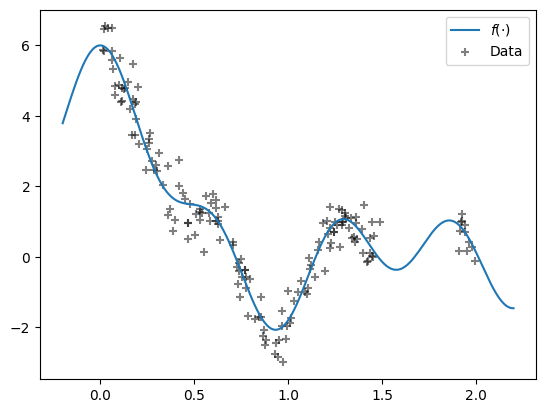

In [4]:
X_train = torch.rand((200, 1)) * 2
X_train = torch.concat([X_train[X_train < 1.5].reshape(-1, 1), X_train[X_train > 1.9].reshape(-1, 1)], 0)
Y_train = func(X_train, noise=True)
data = (X_train, Y_train)
X_test = torch.linspace(-0.2, 2.2, 200, dtype=torch.float64).reshape(-1, 1)

def plot_func(fig, ax):
    plt.plot(X_test, func(X_test, noise=False), label="$f(\cdot)$")
    plt.scatter(X_train[:, 0],
                Y_train[:, 0],
                marker="+",
                color="k",
                alpha=0.5,
                linewidth=1.5,
                label="Data")
    ax.legend()
    

fig, ax = plt.subplots()
plot_func(fig, ax)

## Neural network 

Given the data set $\mathcal{D} = \{(\mathbf{x}_{i} , \mathbf{y}_{i})\}_{i=1}^{N}$, we want to approximate the function $f$ with a neural network $f_\mathbf{w}: \mathbb{R} \to \mathbb{R}$ with weights $\mathbf{w} \in \mathbb{R}^{P}$.
It is common to traing the neural network weights $\mathbf{w}$ to minimize the (regularized) empirical risk,
\begin{equation}
  \mathbf{w}^{*} = 
  \arg \min_{\mathbf{w}} \mathcal{L}(\mathcal{D},\mathbf{w}) =
  \arg \min_{\mathbf{w}} \textstyle\sum_{i=1}^{N} \ell(f_\mathbf{w}(\mathbf{x}_{i}), y_i) + \delta \mathcal{R}(\mathbf{w}).
\end{equation}
where $l(f_\mathbf{w}(\mathbf{x}_{i}), y_i) = -\log(p(y \mid f_\mathbf{w}(\mathbf{x}_{i}))$ and the regularizer $\mathcal{R}(\mathbf{w}) = \frac{1}{2}\| \mathbf{w}\|^{2}_{2}$.
We can view this as the maximum a~posteriori (MAP) solution to a Bayesian objective, where the first term $l(f_\mathbf{w}(\mathbf{x}_{i}), y_i)$ represents the log likelihood and the regularization weight takes the role of a prior precision parameter, $p(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \delta^{-1} \mathbf{I})$.

Let's start by creating a neural network with Tanh activation functions.

In [5]:
width = 64

network = torch.nn.Sequential(
    torch.nn.Linear(1, width),
    # torch.nn.ReLU(),
    # torch.nn.Sigmoid(),
    torch.nn.Tanh(),
    torch.nn.Linear(width, width),
    # torch.nn.ReLU(),
    # torch.nn.Sigmoid(),
    torch.nn.Tanh(),
    torch.nn.Linear(width, 1),
)
print("network: {}".format(network))

network: Sequential(
  (0): Linear(in_features=1, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=1, bias=True)
)


Instantiate SFR (handles NN training/prediction as they're coupled via the prior/likelihood)

In [6]:
delta = 0.0001  # works with tanh

prior = src.priors.Gaussian(params=network.parameters, delta=delta)

In [7]:
sigma_noise = 1.0

likelihood = src.likelihoods.Gaussian(sigma_noise=sigma_noise)

In [8]:
sfr = src.sfr.SFR(
    network=network,
    prior=prior,
    likelihood=likelihood,
    output_dim=1,
    num_inducing=32,
    dual_batch_size=None, # this reduces the memory required for computing dual parameters
    jitter=1e-4,
)

Train the neural network as usual.

In [9]:
num_epochs = 1000
batch_size = 64
learning_rate = 1e-3

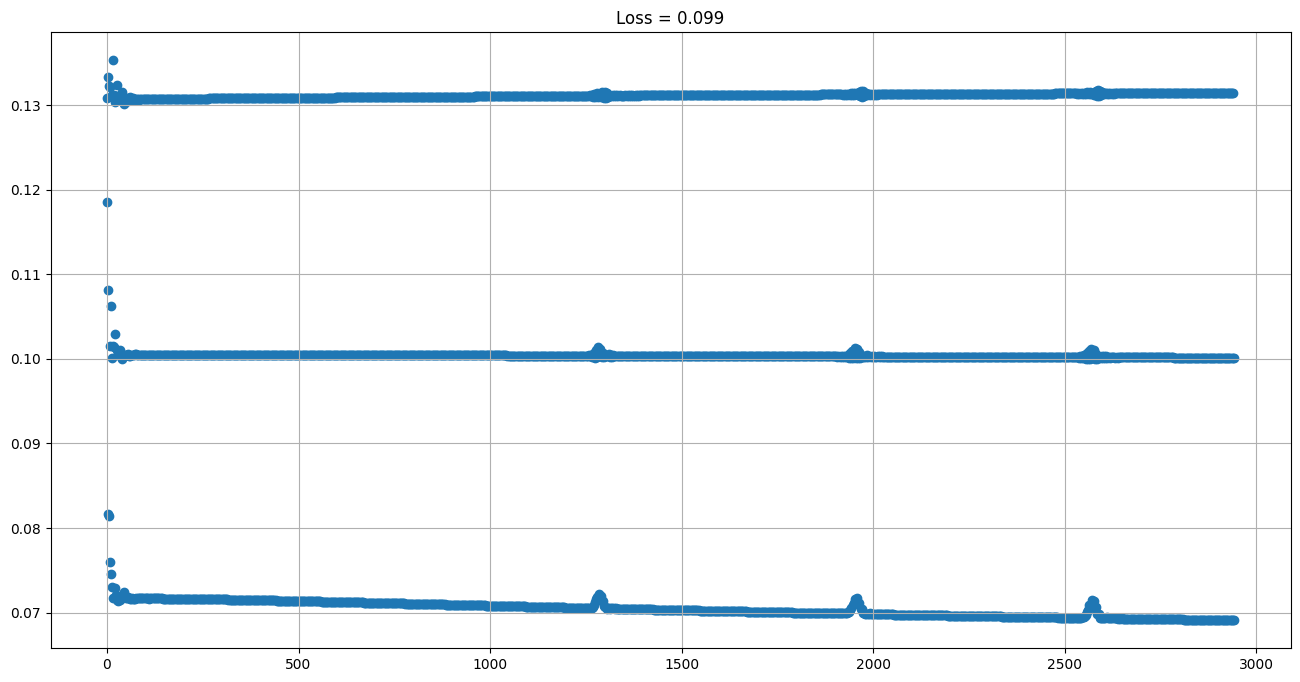

In [18]:
def train(
    sfr: src.SFR,
    data: Data,
    num_epochs: int = 1000,
    batch_size: int = 16,
    learning_rate: float = 1e-3,
) -> dict:
    data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*data), batch_size=batch_size)
    sfr.train()
    optimizer = torch.optim.Adam([{"params": sfr.parameters()}], lr=learning_rate)
    loss_history = []
    for epoch_idx in range(num_epochs):
        for batch_idx, batch in enumerate(data_loader):
            x, y = batch
            loss = sfr.loss(x, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(loss.detach().numpy())
            
        if epoch_idx % 20 == 0:
            clear_output(True)
            plt.figure(figsize=[16, 8])
            plt.subplot()
            plt.title("Loss = %.3f" % np.mean(loss_history[-32:]))
            plt.scatter(np.arange(len(loss_history)), np.array(loss_history))
            plt.grid()
            plt.show()

    return {"loss": loss_history}

metrics = train(sfr=sfr, data=data, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)

Now that we have a trained neural network, we use `src.SFR` to build our sparse GP model.
That is, we perform inference by calculating dual variables,
\begin{equation}
  \label{eq:dual_param_laplace}
  \hat{\alpha}_i := \nabla_{f}\log p(y_i \mid f) |_{f=f_i}
  \quad \text{and} \quad
  \hat{\beta}_i := - \nabla^2_{ff}\log p(y_i \mid f) |_{f=f_i}.
\end{equation}

In [19]:
To perform inference  `src.SFR` samples a set of inducing points

SyntaxError: invalid syntax (1585305084.py, line 1)

In [ ]:
sfr.set_data(data)

## Inference

In [ ]:
f_mean, f_var = sfr.predict_f(X_test)
print(f_mean.shape)
print(f_var.shape)

In [ ]:
def plot_gp(fig, ax, f_mean, f_var):
    ax.plot(X_test, network(X_test).detach()[:, 0], "-", color="r", label="NN", zorder=1)
    ax.plot(X_test, f_mean[:, 0], "-", color="C0", label="Mean", zorder=1)
    ax.fill_between(
            X_test[:, 0],
            (f_mean - 1.96 * torch.sqrt(f_var))[:, 0],
            (f_mean + 1.96 * torch.sqrt(f_var))[:, 0],
            color="C0",
            alpha=0.2,
            label="$95\%$ interval",
            zorder=2,
        )
    ax.scatter(
        sfr.Z.numpy()[:, 0],
        torch.ones_like(sfr.Z) * -5,
        marker="|",
        color="k",
        linewidth=1.5,
        s=30,
        label="Inducing points"
    )
    ax.set_xlim(X_test.numpy().min(), X_test.numpy().max())
    ax.set_ylim(-5.2, 7)
    ax.legend()

fig, ax = plt.subplots()
plot_func(fig, ax)
plot_gp(fig, ax, f_mean, f_var)